In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error

from models import *
from autoencoder import *
from utils import *
from data import *

In [2]:
import os, pickle
import time
import random
import warnings
warnings.filterwarnings("ignore")

In [3]:
latent_dim = 16
ts_configs = [
    ("Temperatures", Temperatures, 31),
    ("Births",       Births,       31),
]

autoencoder_embedding_flags = [False, True]
metrics_list = ["euclidean", "manhattan", "cosine"]


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda



Training AE on Temperatures (window_size=31)
  Epoch 1/30 — loss: 0.488071
  Epoch 2/30 — loss: 0.298063
  Epoch 3/30 — loss: 0.274809
  Epoch 4/30 — loss: 0.258911
  Epoch 5/30 — loss: 0.259722
  Epoch 6/30 — loss: 0.241884
  Epoch 7/30 — loss: 0.228491
  Epoch 8/30 — loss: 0.245672
  Epoch 9/30 — loss: 0.204841
  Epoch 10/30 — loss: 0.228349
  Epoch 11/30 — loss: 0.210305
  Epoch 12/30 — loss: 0.192977
  Epoch 13/30 — loss: 0.190395
  Epoch 14/30 — loss: 0.192576
  Epoch 15/30 — loss: 0.178143
  Epoch 16/30 — loss: 0.195002
  Epoch 17/30 — loss: 0.180281
  Epoch 18/30 — loss: 0.178085
  Epoch 19/30 — loss: 0.167556
  Epoch 20/30 — loss: 0.165607
  Epoch 21/30 — loss: 0.166840
  Epoch 22/30 — loss: 0.163240
  Epoch 23/30 — loss: 0.165269
  Epoch 24/30 — loss: 0.153498
  Epoch 25/30 — loss: 0.165394
  Epoch 26/30 — loss: 0.165829
  Epoch 27/30 — loss: 0.174203
  Epoch 28/30 — loss: 0.163706
  Epoch 29/30 — loss: 0.158672
  Epoch 30/30 — loss: 0.157184
Saved AE: autoencoders\ae_Tempera

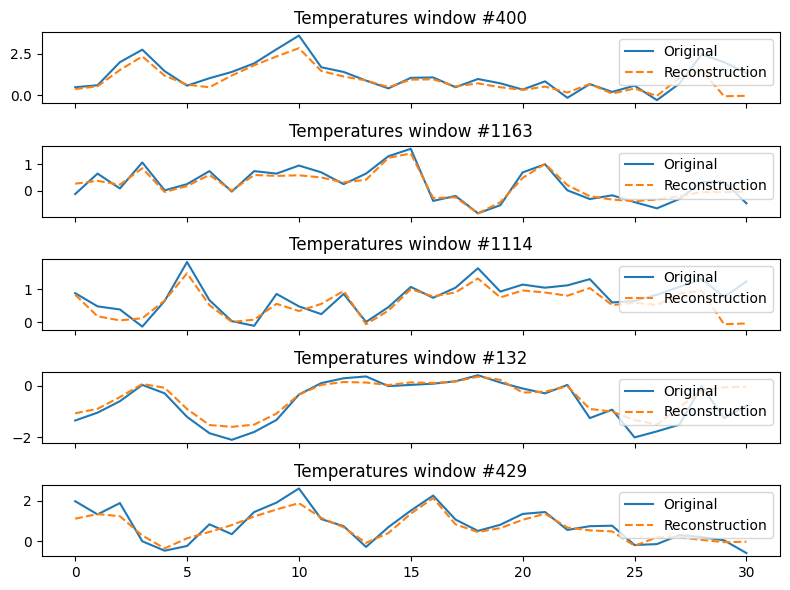

Reconstruction MSE → train: 0.121762, val: 0.099935, test: 0.115126


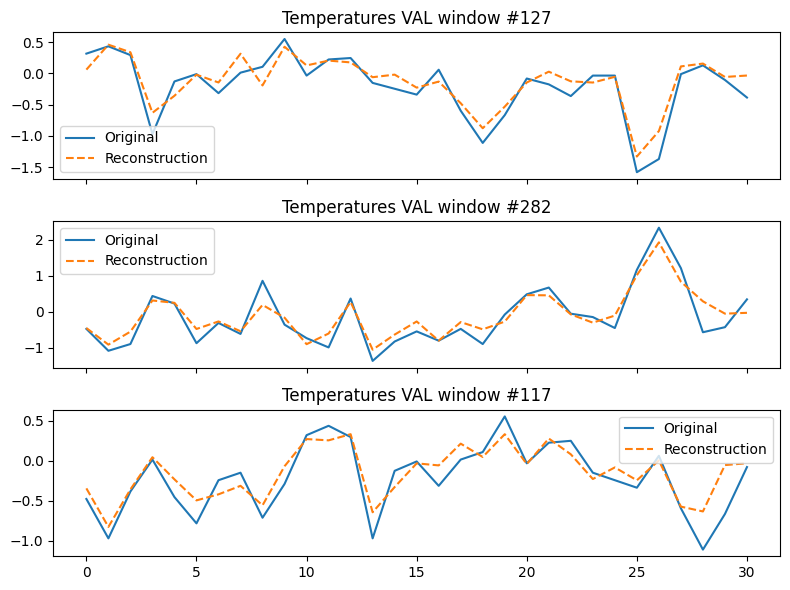


Training AE on Births (window_size=31)
  Epoch 1/30 — loss: 0.375398
  Epoch 2/30 — loss: 0.207811
  Epoch 3/30 — loss: 0.185907
  Epoch 4/30 — loss: 0.166650
  Epoch 5/30 — loss: 0.160544
  Epoch 6/30 — loss: 0.151838
  Epoch 7/30 — loss: 0.149198
  Epoch 8/30 — loss: 0.148153
  Epoch 9/30 — loss: 0.144215
  Epoch 10/30 — loss: 0.142013
  Epoch 11/30 — loss: 0.135719
  Epoch 12/30 — loss: 0.134176
  Epoch 13/30 — loss: 0.131474
  Epoch 14/30 — loss: 0.129096
  Epoch 15/30 — loss: 0.130091
  Epoch 16/30 — loss: 0.129755
  Epoch 17/30 — loss: 0.125993
  Epoch 18/30 — loss: 0.125438
  Epoch 19/30 — loss: 0.124065
  Epoch 20/30 — loss: 0.120272
  Epoch 21/30 — loss: 0.121712
  Epoch 22/30 — loss: 0.120670
  Epoch 23/30 — loss: 0.117954
  Epoch 24/30 — loss: 0.120190
  Epoch 25/30 — loss: 0.117213
  Epoch 26/30 — loss: 0.117981
  Epoch 27/30 — loss: 0.118749
  Epoch 28/30 — loss: 0.118395
  Epoch 29/30 — loss: 0.116890
  Epoch 30/30 — loss: 0.114557
Saved AE: autoencoders\ae_Births.pth


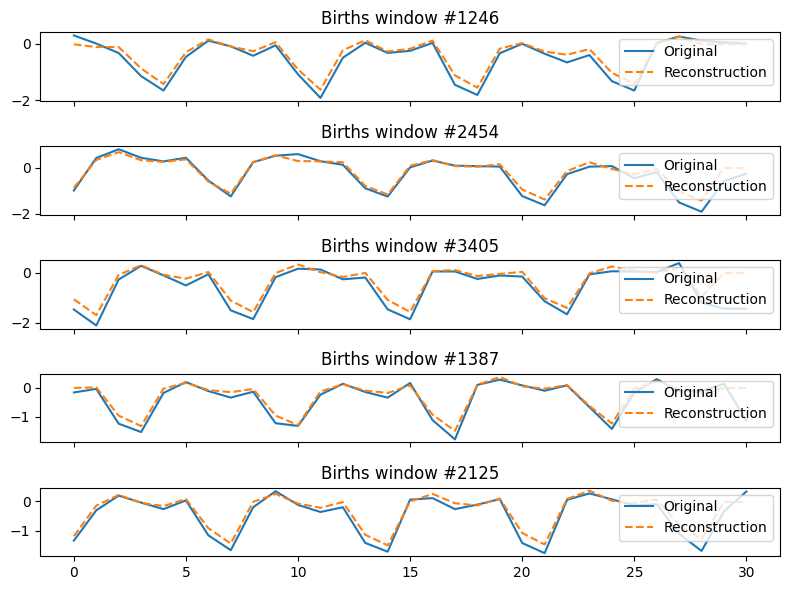

Reconstruction MSE → train: 0.121374, val: 0.195462, test: 0.421171


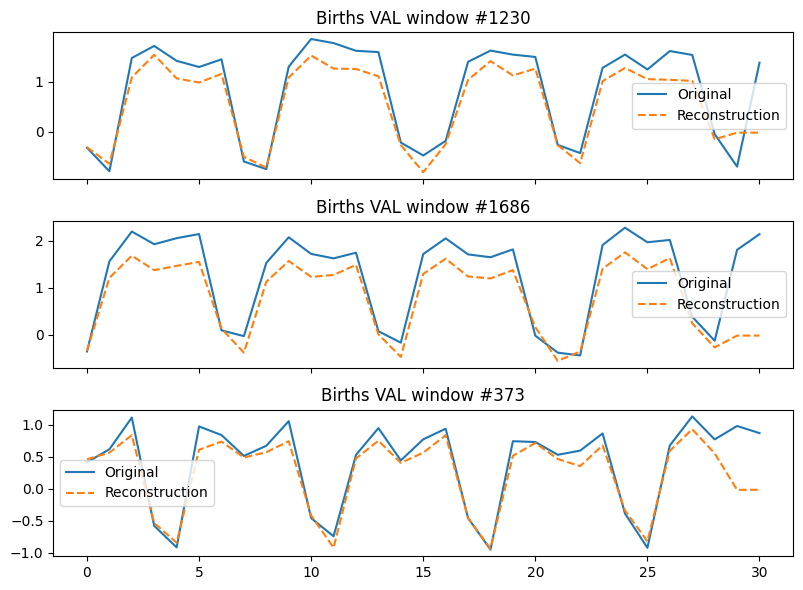

In [4]:
epochs    = 30
lr        = 1e-3
dropout_p = 0.1

for ds_name, DS, window_size in ts_configs:
    print(f"\nTraining AE on {ds_name} (window_size={window_size})")
    ts = DS(path=None)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
    
    
    # model + optimizer + loss
    ae        = ConvAutoencoder1D(window_size, latent_dim, dropout_p).to(device)
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # wrap as DataLoader of shape (batch, 1, window_size)
    ds_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float).unsqueeze(1)),
        batch_size=64, shuffle=True
    )
    
    # training loop
    for epoch in range(1, epochs + 1):
        losses = []
        ae.train()
        for (batch_x,) in ds_loader:
            batch_x = batch_x.to(device)
            recon   = ae(batch_x)
            loss    = criterion(recon, batch_x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f"  Epoch {epoch}/{epochs} — loss: {np.mean(losses):.6f}")
    
    # save per‐dataset autoencoder
    ckpt_path = os.path.join("autoencoders", f"ae_{ds_name}.pth")
    torch.save(ae.state_dict(), ckpt_path)
    print(f"Saved AE: {ckpt_path}")

    # 6. Visualize reconstructions in eval mode
    ae.eval()
    sample_idxs = random.sample(range(len(X_train)), 5)
    fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
    for ax, idx in zip(axes, sample_idxs):
        orig = X_train[idx]
        with torch.no_grad():
            inp = torch.tensor(orig, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)
            recon = ae(inp).cpu().squeeze().numpy()
        ax.plot(orig, label="Original")
        ax.plot(recon, linestyle="--", label="Reconstruction")
        ax.set_title(f"{ds_name} window #{idx}")
        ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

     # 1) Prepare your splits again
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # 2) Compute reconstruction MSE on each split
    def recon_mse(ae, X):
        ae.eval()
        with torch.no_grad():
            # batch through DataLoader if needed; here we do it all at once for simplicity
            X_t = torch.tensor(X, dtype=torch.float).unsqueeze(1).to(device)
            R_t = ae(X_t).cpu().squeeze(1).numpy()
        return ((X - R_t)**2).mean()

    mse_tr  = recon_mse(ae, X_train)
    mse_val = recon_mse(ae, X_val)
    mse_te  = recon_mse(ae, X_test)
    print(f"Reconstruction MSE → train: {mse_tr:.6f}, val: {mse_val:.6f}, test: {mse_te:.6f}")

    # 3) Plot 3 random validation windows vs. reconstructions
    import random
    sample_idxs = random.sample(range(len(X_val)), 3)
    fig, axs = plt.subplots(3,1,figsize=(8,6),sharex=True)
    for ax, idx in zip(axs, sample_idxs):
        orig = X_val[idx]
        with torch.no_grad():
            inp   = torch.tensor(orig, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)
            recon = ae(inp).cpu().squeeze().numpy()
        ax.plot(orig, label="Original")
        ax.plot(recon, "--", label="Reconstruction")
        ax.set_title(f"{ds_name} VAL window #{idx}")
        ax.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
for ds_name, DS, window_size in ts_configs:
    print(f"\n→ Dataset: {ds_name} (window_size={window_size})")
    ts = DS(path=None)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    forecasters = {
    "ARIMA": ARIMAForecaster(),
    "ExpSmoothing": ExpSmoothingForecaster(),
    "LinearRegression": LinearRegressionForecaster(),
    "RandomForest": RandomForestForecaster(),
    "SVR": SVRForecaster(),
    "GradientBoosting": GradientBoostingForecaster(),
    "DT": DecisionTreeForecaster(),
    "MLP": MLPForecaster(),
    "LSTM": LSTMForecaster(window_size=window_size),
    "BiLSTM": BiLSTMForecaster(window_size=window_size),
    "CNNLSTM": CNNLSTMForecaster(window_size=window_size),
    }

    for name, model in forecasters.items():
        print(f"    → Training {name}…", end=" ")
        model.fit(X_train, y_train)

        # save the entire model object as a .pkl
        save_path = os.path.join("models", f"{ds_name}_{name}.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(model, f)
        print(f"DONE: {save_path}")


→ Dataset: Temperatures (window_size=31)
    → Training ARIMA… DONE: models\Temperatures_ARIMA.pkl
    → Training ExpSmoothing… DONE: models\Temperatures_ExpSmoothing.pkl
    → Training LinearRegression… DONE: models\Temperatures_LinearRegression.pkl
    → Training RandomForest… DONE: models\Temperatures_RandomForest.pkl
    → Training SVR… DONE: models\Temperatures_SVR.pkl
    → Training GradientBoosting… DONE: models\Temperatures_GradientBoosting.pkl
    → Training DT… DONE: models\Temperatures_DT.pkl
    → Training MLP… DONE: models\Temperatures_MLP.pkl
    → Training LSTM… 1/30 0.50137 | 15/30 0.34299 | 30/30 0.32894 | DONE: models\Temperatures_LSTM.pkl
    → Training BiLSTM… 1/30 0.50816 | 15/30 0.36651 | 30/30 0.34283 | DONE: models\Temperatures_BiLSTM.pkl
    → Training CNNLSTM… 1/30 0.41516 | 15/30 0.34185 | 30/30 0.27646 | DONE: models\Temperatures_CNNLSTM.pkl

→ Dataset: Births (window_size=31)
    → Training ARIMA… DONE: models\Births_ARIMA.pkl
    → Training ExpSmoothing… 

In [ ]:
MODELS_DIR = "models"
AE_DIR = "autoencoders"

loaded = {}
for ds_name, DS, window_size in ts_configs:
    print(f"\n→ Loading models for {ds_name} (window_size={window_size})")
    
    # 1) Load Autoencoder
    ae = ConvAutoencoder1D(window_size, latent_dim).eval().to(device)
    ae_ckpt = os.path.join(AE_DIR, f"ae_{ds_name}.pth")
    ae.load_state_dict(torch.load(ae_ckpt, map_location=device))
    print(f"     AE loaded from {ae_ckpt}")
    
    # 2) Load Forecasters
    forecasters = {}
    for name in [
        "ARIMA",
        "ExpSmoothing",
        "LinearRegression",
        "RandomForest",
        "SVR",
        "GradientBoosting",
        "DT",
        "MLP",
        "LSTM",
        "BiLSTM",
        "CNNLSTM",
    ]:
        pkl_path = os.path.join(MODELS_DIR, f"{ds_name}_{name}.pkl")
        with open(pkl_path, "rb") as f:
            forecasters[name] = pickle.load(f)
        print(f"     {name} loaded from {pkl_path}")
    
    # store for later
    loaded[ds_name] = {
        "ae": ae,
        "forecasters": forecasters
    }


→ Loading models for Temperatures (window_size=31)
     AE loaded from autoencoders\ae_Temperatures.pth
     ARIMA loaded from models\Temperatures_ARIMA.pkl
     ExpSmoothing loaded from models\Temperatures_ExpSmoothing.pkl
     LinearRegression loaded from models\Temperatures_LinearRegression.pkl
     RandomForest loaded from models\Temperatures_RandomForest.pkl
     SVR loaded from models\Temperatures_SVR.pkl
     GradientBoosting loaded from models\Temperatures_GradientBoosting.pkl
     DT loaded from models\Temperatures_DT.pkl
     MLP loaded from models\Temperatures_MLP.pkl
     LSTM loaded from models\Temperatures_LSTM.pkl
     BiLSTM loaded from models\Temperatures_BiLSTM.pkl
     CNNLSTM loaded from models\Temperatures_CNNLSTM.pkl

→ Loading models for Births (window_size=31)
     AE loaded from autoencoders\ae_Births.pth
     ARIMA loaded from models\Births_ARIMA.pkl
     ExpSmoothing loaded from models\Births_ExpSmoothing.pkl
     LinearRegression loaded from models\Births_L

In [7]:
for ds_name, DS, window_size in ts_configs:
    print(f"\n=== Validation RoC for {ds_name} (window_size={window_size}) ===")
    
    # Load data
    ts = DS(path=None)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # Load models
    ae          = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    # Clear both RoCs
    for model in forecasters.values():
        model.rocs["raw"].clear()
        model.rocs["latent"].clear()

    # Iterate once over validation windows
    for idx, window in enumerate(X_val):
        # a) Pick winner based on raw input
        errors = {}
        for name, model in forecasters.items():
            y_pred = model.predict(window)
            errors[name] = mean_squared_error([y_val[idx]], [y_pred])
        winner = min(errors, key=errors.get)

        # b) Store both raw and latent versions
        raw_vec = window
        with torch.no_grad():
            latent_vec = ae.encode(window).cpu()

        forecasters[winner].rocs["raw"].append(raw_vec)
        forecasters[winner].rocs["latent"].append(latent_vec)

    # Report results
    print("RoC sizes")
    for name, model in forecasters.items():
        count = len(model.rocs["raw"])
        print(f"  {name:<18} {count:4d} entries")



=== Validation RoC for Temperatures (window_size=31) ===
RoC sizes
  ARIMA                81 entries
  ExpSmoothing         66 entries
  LinearRegression     46 entries
  RandomForest         99 entries
  SVR                  75 entries
  GradientBoosting     53 entries
  DT                  131 entries
  MLP                  77 entries
  LSTM                 78 entries
  BiLSTM               69 entries
  CNNLSTM             106 entries

=== Validation RoC for Births (window_size=31) ===
RoC sizes
  ARIMA               106 entries
  ExpSmoothing         63 entries
  LinearRegression    196 entries
  RandomForest        214 entries
  SVR                 172 entries
  GradientBoosting    204 entries
  DT                  188 entries
  MLP                 242 entries
  LSTM                170 entries
  BiLSTM              111 entries
  CNNLSTM             129 entries


In [8]:
# Lists to collect detailed disagreements and high-level summaries
disagreements = []
summary_list = []

print(f"Bottleneck size: {latent_dim}")
for ds_name, DS, window_size in ts_configs:
    print(f"\n=== Dataset: {ds_name} ===")
    # rebuild all splits
    ts = DS(path=None)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
    y_true = y_test if isinstance(y_test, np.ndarray) else y_test.cpu().numpy()

    ae = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]
    n_windows = len(X_test)

    for metric in metrics_list:
        # ---- RAW inference ----
        t0 = time.perf_counter()
        raw_preds, raw_models = [], []
        for w in X_test:
            q = w  # raw query
            # nearest‐RoC lookup in raw space
            best_name, best_dist = None, float("inf")
            for name, model in forecasters.items():
                for entry in model.rocs["raw"]:
                    d = compute_distance(q, entry, metric=metric)
                    if d < best_dist:
                        best_dist, best_name = d, name
            raw_models.append(best_name)
            raw_preds.append(forecasters[best_name].predict(w))
        time_raw = time.perf_counter() - t0
        mse_raw  = mean_squared_error(y_true, raw_preds)

        # ---- LATENT inference ----
        t1 = time.perf_counter()
        lat_preds, lat_models = [], []
        for w in X_test:
            with torch.no_grad():
                q = ae.encode(w).cpu()  # latent query (torch.Tensor)
            best_name, best_dist = None, float("inf")
            for name, model in forecasters.items():
                for entry in model.rocs["latent"]:
                    # entry is already a tensor
                    d = compute_distance(q, entry, metric=metric)
                    if d < best_dist:
                        best_dist, best_name = d, name
            lat_models.append(best_name)
            lat_preds.append(forecasters[best_name].predict(w))
        time_lat = time.perf_counter() - t1
        mse_lat  = mean_squared_error(y_true, lat_preds)

        # ---- Record disagreements ----
        n_dis = 0
        for idx, (rm, lm, yt, pr, pl) in enumerate(zip(raw_models, lat_models, y_true, raw_preds, lat_preds)):
            if rm != lm:
                n_dis += 1
                disagreements.append({
                    "dataset":      ds_name,
                    "metric":       metric,
                    "win_idx":      idx,
                    "raw_model":    rm,
                    "lat_model":    lm,
                    "y_true":       yt,
                    "y_pred_raw":   pr,
                    "y_pred_lat":   pl,
                })
        rate = n_dis / n_windows

        # ---- Append summary ----
        summary_list.append({
            "dataset":          ds_name,
            "metric":           metric,
            "test_mse_raw":     mse_raw,
            "test_mse_lat":     mse_lat,
            "time_raw":         time_raw,
            "time_lat":         time_lat,
            "n_disagreements":  n_dis,
            "disagreement_rate":rate,
        })

        # ---- Print concise line ----
        print(
            f"[{metric:^9}] "
            f"raw MSE={mse_raw:.4f}@{time_raw:.2f}s | "
            f"lat MSE={mse_lat:.4f}@{time_lat:.2f}s | "
            f"dis={n_dis}/{n_windows} ({rate:.2%})"
        )

df_dis  = pd.DataFrame(disagreements)
df_sum  = pd.DataFrame(summary_list)

# save for later
df_dis.to_csv("results/disagreements.csv", index=False)
df_sum.to_csv("results/summary.csv",     index=False)

Bottleneck size: 16

=== Dataset: Temperatures ===
[euclidean] raw MSE=0.3747@3.29s | lat MSE=0.3572@6.70s | dis=598/882 (67.80%)
[manhattan] raw MSE=0.3796@4.18s | lat MSE=0.3557@7.49s | dis=584/882 (66.21%)
[ cosine  ] raw MSE=0.3815@4.86s | lat MSE=0.3692@13.64s | dis=575/882 (65.19%)

=== Dataset: Births ===
[euclidean] raw MSE=0.3555@9.34s | lat MSE=0.3438@22.56s | dis=599/1796 (33.35%)
[manhattan] raw MSE=0.3657@11.79s | lat MSE=0.3687@24.62s | dis=637/1796 (35.47%)
[ cosine  ] raw MSE=0.3066@15.65s | lat MSE=0.2994@49.34s | dis=824/1796 (45.88%)


In [9]:
df_dis['raw_error'] = (df_dis['y_pred_raw'] - df_dis['y_true'])**2
df_dis['lat_error'] = (df_dis['y_pred_lat'] - df_dis['y_true'])**2
df_dis['winner'] = np.where(df_dis['lat_error'] < df_dis['raw_error'],
                            'latent', 'raw')

# 3) Count wins among disagreements
win_counts = (
    df_dis
    .groupby(['dataset','metric','winner'])
    .size()
    .unstack(fill_value=0)
    .rename(columns={'raw':'raw_wins','latent':'latent_wins'})
)

# 4) Compute win‐rates (conditional on disagreement)
win_rates = win_counts.div(win_counts.sum(axis=1), axis=0) \
                      .rename(columns={'raw_wins':'raw_win_rate',
                                       'latent_wins':'latent_win_rate'})

# 5) Merge rates into the summary table
df_full = (
    df_sum
    .merge(win_rates.reset_index(), on=['dataset','metric'], how='left')
    .fillna(0)
    .assign(
        same_decision_rate = 1 - df_sum['disagreement_rate']
    )
)

# 6) Display concise table
display(
    df_full[[
        'dataset','metric',
        'raw_win_rate','latent_win_rate','same_decision_rate'
    ]]
)

,dataset,metric,raw_win_rate,latent_win_rate,same_decision_rate
0,Temperatures,euclidean,0.505017,0.494983,0.321995
1,Temperatures,manhattan,0.510274,0.489726,0.337868
2,Temperatures,cosine,0.469565,0.530435,0.348073
3,Births,euclidean,0.507513,0.492487,0.666481
4,Births,manhattan,0.514914,0.485086,0.645323
5,Births,cosine,0.492718,0.507282,0.541203
